In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
from src.efficient_kan import KAN

/root/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
from tqdm import tqdm

In [4]:
import numpy as np
import random

In [23]:
config = {}
config['input_dim'] = 1024*16
config['batch_size'] = 64
config['hidden_layers'] = [1024, 256]
config['lr'] = 1e-3
config['gamma'] = 0.9
config['period'] = 2

In [24]:
class kae_dataset(Dataset):
    def __init__(self, num_data=100, input_dim=128):
        super(kae_dataset, self).__init__()
        self.num_data = num_data
        self.target = []
        for i in range(num_data):
            scale = random.random()
            phase_left = random.random() + 0.1
            phase_right = random.random() + 0.1
            x=np.arange(-phase_left*2*np.pi*config['period'],phase_right*2*np.pi*config['period'],(phase_right*2*np.pi+phase_left*2*np.pi)*config['period']/input_dim)
            x=x.reshape(len(x),1)
            y=scale * np.sin(x)
            self.target.append(y)

    def __getitem__(self, index):
        target = torch.from_numpy(self.target[index]).squeeze().unsqueeze(0).to(torch.float32)
        return target

    def __len__(self):
        return len(self.target)

trainset = kae_dataset(10000, config['input_dim'])
valset = kae_dataset(100, config['input_dim'])
trainloader = DataLoader(trainset, batch_size=config['batch_size'], shuffle=True)
valloader = DataLoader(valset, batch_size=config['batch_size'], shuffle=False)

In [25]:
class VectorQuantizer(nn.Module):
    """
    Reference:
    [1] https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py
    """
    def __init__(self,
                 num_embeddings: int,
                 embedding_dim: int,
                 beta: float = 0.25):
        super(VectorQuantizer, self).__init__()
        self.K = num_embeddings
        self.D = embedding_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.K, self.D)
        self.embedding.weight.data.uniform_(-1 / self.K, 1 / self.K)

    def forward(self, latents):
        # Compute L2 distance between latents and embedding weights
        dist = torch.sum(latents ** 2, dim=1, keepdim=True) + \
               torch.sum(self.embedding.weight ** 2, dim=1) - \
               2 * torch.matmul(latents, self.embedding.weight.t())  # [BHW x K]

        # Get the encoding that has the min distance
        encoding_inds = torch.argmin(dist, dim=1).unsqueeze(1)  # [BHW, 1]

        # Convert to one-hot encodings
        device = latents.device
        encoding_one_hot = torch.zeros(encoding_inds.size(0), self.K, device=device)
        encoding_one_hot.scatter_(1, encoding_inds, 1)  # [BHW x K]

        # Quantize the latents
        quantized_latents = torch.matmul(encoding_one_hot, self.embedding.weight)  # [BHW, D]

        # Compute the VQ Losses
        commitment_loss = F.mse_loss(quantized_latents.detach(), latents)
        embedding_loss = F.mse_loss(quantized_latents, latents.detach())

        vq_loss = commitment_loss * self.beta + embedding_loss

        # Add the residue back to the latents
        quantized_latents = latents + (quantized_latents - latents).detach()

        return quantized_latents, vq_loss  # [B x D x H x W]
        
class KVQ_VAE(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        input_dim,
        K,
        beta,
    ):
        super(KVQ_VAE, self).__init__()
        self.layers_hidden = layers_hidden
        self.input_dim = input_dim
        self.K = K
        self.beta = beta
        self.encoder = KAN([input_dim, layers_hidden[0], layers_hidden[1]])
        self.VQ = VectorQuantizer(self.K, layers_hidden[1], beta=self.beta)
        self.decoder = KAN([layers_hidden[1], layers_hidden[0], input_dim])

    def encode(self, input):
        posterior_dist = self.encoder(input)

        # Split the result into miu and sigma components
        # of the latent Gaussian distribution

        return posterior_dist

    def decode(self, z):
        priori_dist = self.decoder(z)
        return priori_dist

    def forward(self, input, **kwargs):
        encoding = self.encode(input)
        quantized_inputs, vq_loss = self.VQ(encoding)
        return [self.decode(quantized_inputs), vq_loss]

    def loss_function(self,
                      input, 
                      ouput, 
                      vq_loss):

        recons_loss = F.mse_loss(ouput, input)

        loss = recons_loss + 10*vq_loss
        return {'loss': loss,
                'Reconstruction_Loss': recons_loss,
                'VQ_Loss':vq_loss}


In [26]:
# Define model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KVQ_VAE(layers_hidden=config['hidden_layers'], input_dim=config['input_dim'], K=1024, beta=20)
model.to(device)
# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=config['gamma'])

# Define loss
criterion = nn.MSELoss()

In [27]:
for epoch in range(10):
    # Train
    model.train()
    with tqdm(trainloader) as pbar:
        for i, targets in enumerate(pbar):
            targets = targets.view(-1, config['input_dim']).to(device)
            optimizer.zero_grad()
            output, vq_loss = model(targets)
            loss = model.loss_function(output, targets, vq_loss)
            loss['loss'].backward()
            optimizer.step()
            pbar.set_postfix(loss=loss['loss'].item(), recon_loss=loss['Reconstruction_Loss'].item(), vq_loss=loss['VQ_Loss'].item(), lr=optimizer.param_groups[0]['lr'])

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for targets in valloader:
            targets = targets.view(-1, config['input_dim']).to(device)
            output, vq_loss = model(targets)
            loss = model.loss_function(output, targets, vq_loss)
            val_loss += loss['loss'].item()
            
    val_loss /= len(valloader)

    # Update learning rate
    scheduler.step()

    print(
        f"Epoch {epoch + 1}, Val Loss: {val_loss}"
    )

100%|██████████| 157/157 [00:08<00:00, 19.21it/s, loss=0.0976, lr=0.001, recon_loss=0.0749, vq_loss=0.00228]


Epoch 1, Val Loss: 0.10498609393835068


100%|██████████| 157/157 [00:08<00:00, 19.58it/s, loss=0.0386, lr=0.0009, recon_loss=0.0313, vq_loss=0.000737]


Epoch 2, Val Loss: 0.051583174616098404


100%|██████████| 157/157 [00:07<00:00, 19.84it/s, loss=0.0305, lr=0.00081, recon_loss=0.017, vq_loss=0.00135]  


Epoch 3, Val Loss: 0.04014810919761658


100%|██████████| 157/157 [00:07<00:00, 19.71it/s, loss=0.0226, lr=0.000729, recon_loss=0.0131, vq_loss=0.000951]


Epoch 4, Val Loss: 0.03453323617577553


100%|██████████| 157/157 [00:07<00:00, 20.23it/s, loss=0.0283, lr=0.000656, recon_loss=0.0154, vq_loss=0.00129] 


Epoch 5, Val Loss: 0.034112850204110146


100%|██████████| 157/157 [00:07<00:00, 20.23it/s, loss=0.0348, lr=0.00059, recon_loss=0.0186, vq_loss=0.00162]


Epoch 6, Val Loss: 0.03113653976470232


100%|██████████| 157/157 [00:07<00:00, 20.01it/s, loss=0.0243, lr=0.000531, recon_loss=0.0123, vq_loss=0.0012]  


Epoch 7, Val Loss: 0.03292657807469368


100%|██████████| 157/157 [00:07<00:00, 19.66it/s, loss=0.0233, lr=0.000478, recon_loss=0.0118, vq_loss=0.00115] 


Epoch 8, Val Loss: 0.031142178922891617


100%|██████████| 157/157 [00:07<00:00, 20.08it/s, loss=0.0221, lr=0.00043, recon_loss=0.0117, vq_loss=0.00105] 


Epoch 9, Val Loss: 0.031238263472914696


100%|██████████| 157/157 [00:07<00:00, 20.22it/s, loss=0.0267, lr=0.000387, recon_loss=0.0148, vq_loss=0.00118]  


Epoch 10, Val Loss: 0.03166843205690384


In [10]:
import matplotlib.pyplot as plt

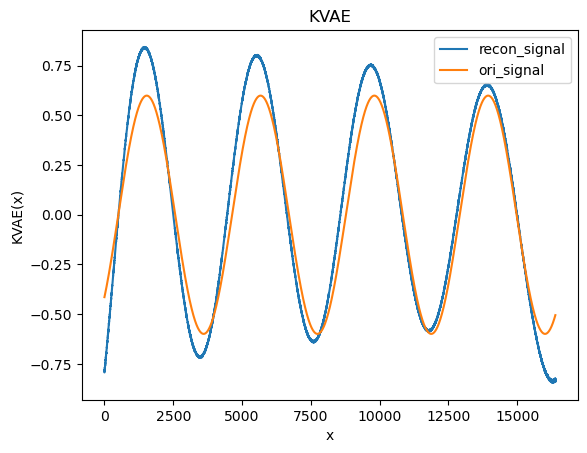

In [29]:
idx = 20
pred = model(trainset[idx].to(device))[0].detach().cpu().numpy()[0]
x = np.linspace(0, config['input_dim'], config['input_dim'])
plt.plot(x, pred, label='recon_signal')
plt.plot(x, trainset[idx][0], label='ori_signal')
plt.xlabel('x')
plt.ylabel('KVAE(x)')
plt.title('KVAE')
plt.legend()
plt.savefig('assets/recon_signal.jpg')
plt.show()